# Regularization-wise double descent in two layer neural networks

In [15]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
import warnings

import argparse
import os
import datetime
import pathlib
import random
import json
import numpy as np
import math

import torch

import sys
sys.path.append('../code/')
from linear_utils import linear_model
from train_utils import save_config

In [16]:
num_weight_decay_points = 50

## Experiment configuration

[Jumpy to Jacobian analysis](#Jacobian)

In [17]:
# argument written in command line format
cli_args = ('--seed 18 --save-results --risk-loss L1 -t 1000 -w 1 1' # '--lr 0.000001 0.00008' 
#             ' '
#             '--lr 0.000001 0.00012'
            ' '
            '--lr 0.0000015 0.00005'
            ' '
            '--weight-decay -2 4 --wd-sample log'
            ' '
            '--wd-scale 1 5'
            ' '
            '-d 50 -n 100 --hidden 250' 
            ' '
            '--sigmas geo --s-range 1 4 --sigma-noise 11.0'
            ' '
            '--details increasing the lr further for l2 experiments'
            ' '
            '--save-results'
           )

In [18]:
"""
A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing the MSE loss.
"""

# get CLI parameters
parser = argparse.ArgumentParser(description='CLI parameters for training')
parser.add_argument('--root', type=str, default='', metavar='DIR',
                    help='Root directory')
parser.add_argument('-t', '--iterations', type=int, default=1e4, metavar='ITERATIONS',
                    help='Iterations (default: 1e4)')
parser.add_argument('-n', '--samples', type=int, default=100, metavar='N',
                    help='Number of samples (default: 100)')
parser.add_argument('--print-freq', type=int, default=1000,
                    help='CLI output printing frequency (default: 1000)')
parser.add_argument('--gpu', type=int, default=None,
                    help='Number of GPUS to use')
parser.add_argument('--seed', type=int, default=None,
                    help='Random seed')                        
parser.add_argument('-d', '--dim', type=int, default=50, metavar='DIMENSION',
                    help='Feature dimension (default: 50)')
parser.add_argument('--hidden', type=int, default=200, metavar='DIMENSION',
                    help='Hidden layer dimension (default: 200)')
parser.add_argument('--sigmas', type=str, default=None,
                    help='Sigmas')     
parser.add_argument('-r','--s-range', nargs='*', type=float,
                    help='Range for sigmas')
parser.add_argument('--normalized', action='store_true', default=False,
                    help='normalize sample norm across features')
parser.add_argument('--sigma-noise', type=float, default=0.0, metavar='NOISE',
                    help='Noise variance')
parser.add_argument('-w','--scales', nargs='*', type=float,
                    help='scale of the weights')
parser.add_argument('--lr', type=float, default=1e-4, nargs='*', metavar='LR',
                    help='learning rate (default: 1e-4)')
parser.add_argument('--weight-decay', type=float, default=1e-4, nargs='*', metavar='L2',
                    help='Weight decay')
parser.add_argument('--wd-sample', type=str, default='', choices=('', 'lin', 'log'),
                    help='Sample multiple weight decays from an interval')
parser.add_argument('--wd-scale', type=float, default=1.0, nargs='*', metavar='SCALE',
                    help='Layer-wise scales for the weight decay')
parser.add_argument('--risk-loss', type=str, default='MSE', metavar='LOSS',
                    help='Loss for validation')
parser.add_argument('--jacobian', action='store_true', default=False,
                    help='compute the SVD of the jacobian of the network')
parser.add_argument('--save-results', action='store_true', default=False,
                    help='Save the results for plots')
parser.add_argument('--details', type=str, metavar='N', nargs='*',
                    default=['no', 'details', 'given'],
                    help='details about the experimental setup')


args = parser.parse_args(cli_args.split())

# directories
root = pathlib.Path(args.root) if args.root else pathlib.Path.cwd().parent

current_date = str(datetime.datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
args.outpath = (pathlib.Path.cwd().parent / 'results' / 'two_layer_nn' /  current_date)

# details
args.details = ' '.join(args.details)

# sample weight decay values
if not args.wd_sample:
    args.weight_decay = [args.weight_decay] if not isinstance(args.weight_decay, list) else args.weight_decay
elif args.wd_sample == 'lin':
    args.weight_decay = list(np.linspace(args.weight_decay[0], args.weight_decay[1], num=50))
elif args.wd_sample == 'log':
#     for w in args.weight_decay:
#         if w > 1:
#             raise ValueError("Weight decay values are not approporiate for log sampling.")
    args.weight_decay = list(np.logspace(args.weight_decay[0], args.weight_decay[1], num=50))
else:
    raise ValueError("Sample selection {} for weight decay not supported!".format(args.wd_sample))
    

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)


# testing for different random seeds for the linear model
# random.seed(test_rnd)
# np.random.seed(test_rnd)
    
# device = torch.device('cpu')
device = torch.device('cuda') # Uncomment this to run on GPU

In [19]:
d_out = 1      # dimension of y

# sample training set from the linear model
lin_model = linear_model(args.dim, 
                         sigma_noise=args.sigma_noise, 
                         normalized=args.normalized, 
                         sigmas=args.sigmas, 
                         s_range=args.s_range)
Xs, ys = lin_model.sample(args.samples)
Xs = torch.Tensor(Xs).to(device)
ys = torch.Tensor(ys.reshape((-1,1))).to(device)

# sample the set for empirical risk calculation
Xt, yt = lin_model.sample(args.samples)
Xt = torch.Tensor(Xt).to(device)
yt = torch.Tensor(yt.reshape((-1,1))).to(device)

In [20]:
# define loss functions
loss_fn = torch.nn.MSELoss(reduction='sum').to(device)
risk_fn = torch.nn.L1Loss(reduction='mean').to(device) if args.risk_loss == 'L1' else loss_fn

In [21]:
def rescale_model_weights(model, scales):
    
    #### re-initialize the weights (regular initialization is too unstable)
    # if args.scales:
    #     i = 0
    #     with torch.no_grad():
    #         for m in model:
    #             if type(m) == torch.nn.Linear:
    #                 if i == 0:
    #                     m.weight.data.normal_(0, args.scales[0])
    #                 if i == 1:
    #                     m.weight.data.uniform_(-args.scales[1], args.scales[1])
    #                 i += 1


    # use kaiming initialization instead
    i = 0
    with torch.no_grad():
        for m in model:
            if type(m) == torch.nn.Linear:
                if i == 0:
                    torch.nn.init.kaiming_normal_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, scales[0])
                if i == 1:
                    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, scales[1])
                i += 1
                

def get_jacobian_two_layer(X, y, model, crit):
    
    grads = []
    for cx, cy in zip(X, y):

        cur_grads = []
        model.zero_grad()
        co = model(cx)
        co.backward(torch.ones(len(cy)))

        for p in model.parameters():
            if p.grad is not None and len(p.data.shape)>1:
                cur_grads.append(p.grad.data.numpy().flatten())
        grads.append(np.concatenate(cur_grads))
    return np.array(grads)

## Scaled $\lambda$

In [22]:
wd_logs = {}
for wd in [0] + args.weight_decay:
    
    print('training with weight decay {}'.format(wd))
    
    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        np.random.seed(args.seed)

    # Two layer neural network in pytorch
    model = torch.nn.Sequential(
              torch.nn.Linear(args.dim, args.hidden),
              torch.nn.ReLU(),
              torch.nn.Linear(args.hidden, d_out),
            ).to(device)

    if args.scales:
        rescale_model_weights(model, args.scales)


    # use same learning rate for the two layers in case of a single learning rate or none.
    if not isinstance(args.wd_scale, list):
        print('[WARNING!] {} is not a valid weight decay scale for a 2 layer network!'.format(args.wd_scale))
        break

    # train the network
    losses = []
    risks = []
    for t in range(int(args.iterations)):
        y_pred = model(Xs)

        loss = loss_fn(y_pred, ys)
        losses.append(loss.item())

        if not t % args.print_freq:
            print(t, loss.item())

        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            i = 0
            for param in model.parameters():
                param.data -= args.lr[i] * (param.grad + wd * args.wd_scale[i] * param.data)
                if not len(param.shape) > 1:
                    i += 1

        with torch.no_grad():
            yt_pred = model(Xt)

            risk = risk_fn(yt_pred, yt)
            risks.append(risk.item())

            if not t % args.print_freq:
                print(t, risk.item())
                
    wd_logs.update({wd: {'loss': losses, 'risk': risks}})

training with weight decay 0
0 38146.15625
0 14.04727554321289
training with weight decay 0.01
0 38146.15625
0 14.04727554321289
training with weight decay 0.013257113655901088
0 38146.15625
0 14.04727554321289
training with weight decay 0.017575106248547922
0 38146.15625
0 14.04727554321289
training with weight decay 0.023299518105153717
0 38146.15625
0 14.04727554321289
training with weight decay 0.030888435964774818
0 38146.15625
0 14.04727554321289
training with weight decay 0.040949150623804255
0 38146.15625
0 14.04727554321289
training with weight decay 0.054286754393238594
0 38146.15625
0 14.04727554321289
training with weight decay 0.07196856730011521
0 38146.15625
0 14.04727554321289
training with weight decay 0.09540954763499938
0 38146.15625
0 14.04727554321289
training with weight decay 0.12648552168552957
0 38146.15625
0 14.04727554321289
training with weight decay 0.16768329368110083
0 38146.15625
0 14.04727554321289
training with weight decay 0.22229964825261944
0 38146.

### Constant $\lambda$

Train the network with the same regularization strength for both layers

In [23]:
wd_logs_same = {}
for wd in [0] + args.weight_decay:
    
    print('training with weight decay {}'.format(wd))
    
    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        np.random.seed(args.seed)
    
    model = torch.nn.Sequential(
               torch.nn.Linear(args.dim, args.hidden),
               torch.nn.ReLU(),
               torch.nn.Linear(args.hidden, d_out),
             ).to(device)      

    # use kaiming initialization
    if args.scales:
        rescale_model_weights(model, args.scales)


    # use same learning rate for the two layers
    if isinstance(args.lr, list):
        stepsize = [max(args.lr)] * 2

    # train the network
    losses_same = []
    risks_same = []
    for t in range(int(args.iterations)):
        y_pred = model(Xs)

        loss = loss_fn(y_pred, ys)
        losses_same.append(loss.item())

        if not t % args.print_freq:
            print(t, loss.item())

        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            i = 0
            for param in model.parameters():
                param.data -= stepsize[i] * (param.grad + wd * param.data)
                if not len(param.shape) > 1:
                    i += 1

        with torch.no_grad():
            yt_pred = model(Xt)

            risk = risk_fn(yt_pred, yt)
            risks_same.append(risk.item())

            if not t % args.print_freq:
                print(t, risk.item())
                
    wd_logs_same.update({wd: {'loss': losses_same, 'risk': risks_same}})

training with weight decay 0
0 38146.15625
0 13.982481002807617
training with weight decay 0.01
0 38146.15625
0 13.9824800491333
training with weight decay 0.013257113655901088
0 38146.15625
0 13.982481002807617
training with weight decay 0.017575106248547922
0 38146.15625
0 13.9824800491333
training with weight decay 0.023299518105153717
0 38146.15625
0 13.9824800491333
training with weight decay 0.030888435964774818
0 38146.15625
0 13.9824800491333
training with weight decay 0.040949150623804255
0 38146.15625
0 13.9824800491333
training with weight decay 0.054286754393238594
0 38146.15625
0 13.9824800491333
training with weight decay 0.07196856730011521
0 38146.15625
0 13.9824800491333
training with weight decay 0.09540954763499938
0 38146.15625
0 13.9824800491333
training with weight decay 0.12648552168552957
0 38146.15625
0 13.9824800491333
training with weight decay 0.16768329368110083
0 38146.15625
0 13.982481002807617
training with weight decay 0.22229964825261944
0 38146.15625


In [24]:
risk_wd0 = wd_logs_same[0]['risk']
loss_wd0 = wd_logs_same[0]['loss']
risks = []
risks_same = []

for w in args.weight_decay:
    risks.append(wd_logs[w]['risk'][-1])
    risks_same.append(wd_logs_same[w]['risk'][-1])

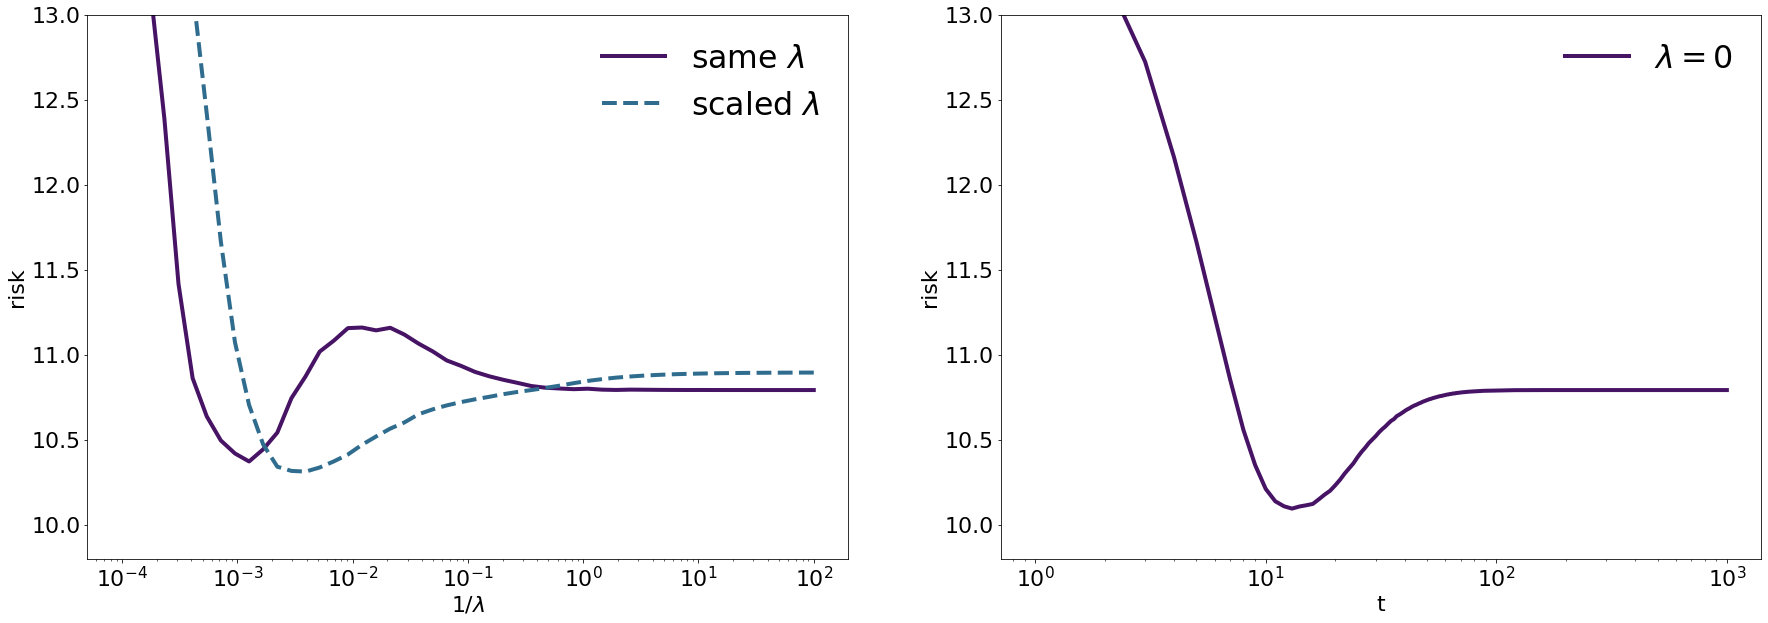

In [32]:
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = [r'same $\lambda$', 'scaled $\lambda$']

fig = plt.figure(figsize=(30,10))
ax = plt.subplot(121)


ax.plot(1/np.array(args.weight_decay)[:len(risks_same)], risks_same, 
        color=colorList[0], 
        label=labelList[0],
        lw=4)
ax.plot(1/np.array(args.weight_decay)[:len(risks)], risks, 
        color=colorList[1], 
        label=labelList[1],
        ls='dashed',
        lw=4)

ax2 = plt.subplot(122)
ax2.plot(np.arange(len(risk_wd0)), risk_wd0, 
        color=colorList[0], 
        label=r'$\lambda=0$',
        lw=4)

axlist = [ax, ax2]
for cur_ax in axlist:
    cur_ax.set_xscale('log')
    cur_ax.set_ylim([9.8, 13.0])
    cur_ax.legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
        frameon=False, fancybox=True, shadow=True, ncol=1)
    cur_ax.set_ylabel('risk')
    

ax.set_xlabel(r'$1/\lambda$')
ax2.set_xlabel('t')

plt.show()

In [124]:
# post-observation details for the config file
args.details = "regularization-wise double descent and no epoch-wise double descent."

In [125]:
if args.save_results:
    args.outpath.mkdir(exist_ok=True, parents=True)
    save_config(args)
    
    np_save_file = args.outpath / ('regularized_2NN_full_k-{}'.format(args.hidden) + '.txt')

    np.savetxt(np_save_file, 
               np.column_stack((args.weight_decay, 
                                risks_same,
                                risks
                               )), 
               header=('lambda risk'
                       ' scaled'
                      ), 
               comments='',
               newline='\n' )
    
    
    np_save_file_wd0 = args.outpath / ('regularized_2NN_wd0_k-{}.txt')

    np.savetxt(np_save_file_wd0, 
               np.column_stack((np.arange(args.iterations), 
                                risk_wd0,
                                loss_wd0
                               )), 
               header=('lambda risk'
                       ' loss'
                      ), 
               comments='',
               newline='\n' )

## Gradient descent analysis

[Jump back to CLI configuration](#Experiment-configuration)

In [12]:
def train_two_layer(Xs, ys, Xt, yt, args, 
                    iterations = 100,
                    print_freq = 100,
                    stepsize = 0.001,
                    weight_decay = 0,
                    jacobian = False,
                    track_params = False,
                    track_jacobian_params = False,
                    track_grads = False
                   ):
    print('training with weight decay {}'.format(weight_decay))
    if print_freq >= iterations:
        print('t \t loss \t risk')
    
    track_params = (track_jacobian_params or track_params)
    
    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        np.random.seed(args.seed)
        
    model = torch.nn.Sequential(
               torch.nn.Linear(args.dim, args.hidden, bias=(not args.bias_off)),
               torch.nn.ReLU(),
               torch.nn.Linear(args.hidden, d_out, bias=(not args.bias_off)),
             ).to(device)      

    # use kaiming initialization
    if args.scales:
        rescale_model_weights(model, args.scales, args.init_method)
        
    if jacobian or track_jacobian_params:
        J_old = get_jacobian_two_layer(Xs, ys, model, loss_fn)
        
        # initialize for records
        J_change = []
        J_mean_change = []
        
    if track_jacobian_params:
        uv, sv, vtv = np.linalg.svd(J_old)
        
        # initialize for records
        v_rel_change = []
        v_ort_change = []
        
    if track_params:
        par_0 = [p.data.numpy().flatten() for p in model.parameters()]
        par_old = par_0.copy()
        
        # initialize for records
        par_change = []
        par_rel_change = []
        
    if track_grads:
        grad_hist = []
        
        
    # train the network
    losses = []
    risks = []
    for t in range(int(iterations)):
        y_pred = model(Xs)

        loss = loss_fn(y_pred, ys)
        losses.append(loss.item())
        
        if track_params: 
            par_t = []
        if track_grads: 
            grad_t = []
            
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            i = 0
            for param in model.parameters():
                param.data -= stepsize[i] * (param.grad + weight_decay * param.data)
                if not len(param.shape) > 1:
                    i += 1

                if track_params: 
                    par_t.append(param.data.numpy().flatten())
                if track_grads: 
                    grad_t.append(param.grad.numpy().flatten())
                
        if track_grads:
            grad_hist.append([ (np.histogram(p, bins=100, density=True)) for p in grad_t ])
        if track_params:
            par_change.append([( np.linalg.norm(p - par_0[i]) / np.linalg.norm(par_0[i]) )**2 for i, p in enumerate(par_t)])
            par_rel_change.append([( np.linalg.norm(p - par_old[i]) / np.linalg.norm(par_old[i]) )**2 for i, p in enumerate(par_t)])
            par_old = par_t.copy()
        if jacobian:
            J_new = get_jacobian_two_layer(Xs, ys, model, loss_fn)
            J_change.append(np.linalg.norm(J_new - J_old)**2 / np.linalg.norm(J_old)**2)
            J_mean_change.append(np.mean((J_new - J_old) ** 2))
            J_old = J_new.copy()

        if track_jacobian_params:
            # compute the change in the parameters in the relevant and unrelevant directions
            par_raw_change = np.concatenate( [p - par_0[i] for i, p in enumerate(par_t)] )
            v_rel_change.append( np.linalg.norm(vtv[:sv.shape[0]] @ par_raw_change)**2 )
            v_ort_change.append( np.linalg.norm(vtv[sv.shape[0]:] @ par_raw_change)**2 )
        

        with torch.no_grad():
            yt_pred = model(Xt)

            risk = risk_fn(yt_pred, yt)
            risks.append(risk.item())
        
        if not t % args.print_freq:
            print('{} \t {} \t {}'.format(t, loss.item(), risk.item()))
            
        
    res = {'loss': losses, 'risk': risks}
    if jacobian:
        res.update({'jacobian_change': J_change, 'mean_jacobian_change': J_mean_change})
    if track_grads:
        res.update({'gradient_histogram': grad_hist})
    if track_params:
        res.update({'initialization_parameter_change': par_change, 'iterative_parameter_change': par_rel_change})
    if track_jacobian_params:
        res.update({'relevant_parameter_change': v_rel_change, 'non-relevant_parameter_change': v_ort_change})
    return res

In [22]:
args.weight_decay = [0.1, 500]

train_args = {}
train_args['iterations'] = 100
train_args['print_freq'] = 50

# use same learning rate for the two layers
if isinstance(args.lr, list):
    train_args['stepsize'] = [max(args.lr)] * 2
    
train_args['jacobian'] = False
train_args['track_grads'] = False
train_args['track_params'] = True
train_args['track_jacobian_params'] = True

wd_results = {}
for wd in args.weight_decay:
    
    train_args['weight_decay'] = wd
    res = train_two_layer(Xs, ys, Xt, yt, args, **train_args)
    wd_results[wd] = {k: v for k, v in res.items()}
    
print('DONE!')

training with weight decay 0.1
0 	 382.0858459472656 	 14.204567909240723
training with weight decay 500
0 	 382.0858459472656 	 14.204673767089844
DONE!


### Relevant change in the network parameters

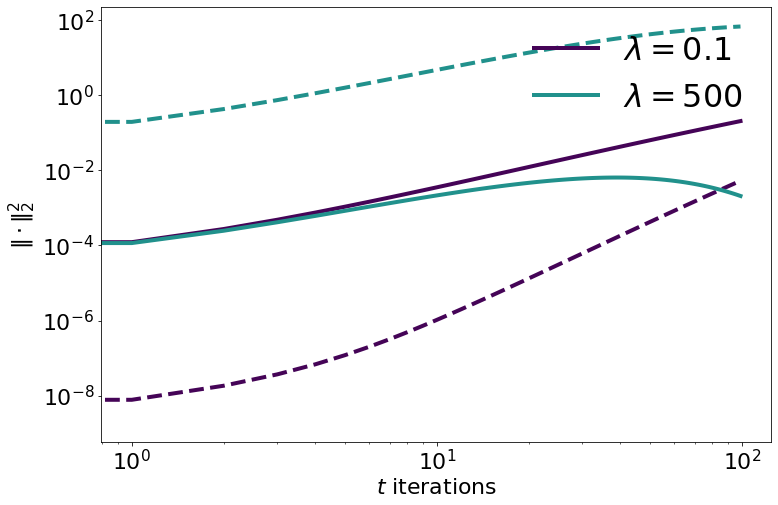

In [23]:
# cur_wd = wd_test

cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
colorList = [cmap(i) for i in np.linspace(0.01,0.99,3)]
labelList = [r'$\Vert \; V^T (\theta_t - \theta_0) \; \Vert_2^2$', 
             r'$\Vert \; \tilde V^T (\theta_t - \theta_0) \; \Vert_2^2$']

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')

# for i, wd in enumerate(args.weight_decay):
for i, wd in enumerate([0.1, 500]):
    ax.plot(np.arange(train_args['iterations']), wd_results[wd]['relevant_parameter_change'], 
            color=colorList[i], 
            label=r'$\lambda={}$'.format(wd),
            lw=4)
    ax.plot(np.arange(train_args['iterations']), wd_results[wd]['non-relevant_parameter_change'], 
            color=colorList[i], 
            # label=r'$\lambda={}$'.format(wd) + labelList[1],
            ls='dashed',
            lw=4)

# ax.legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
#           frameon=False, fancybox=True, shadow=True, ncol=1)
ax.set_ylabel(r'$\Vert \cdot \Vert_2^2$')
ax.set_xlabel(r'$t$ iterations')
# ax.set_title(r'Non-linear; $\lambda$ = {}'.format(cur_wd))

ax.legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
          frameon=False, fancybox=True, shadow=True, ncol=1)

plt.show()